# 누락된 데이터 다루기
* 숫자가 아니라는 의미의 NaN(not a number)
* NULL(관계형 데이터베이스에서 모르는 값을 지칭하는 데 주로 사용)

### 테이블 형태 데이터에서 누락된 값 식별

In [1]:
import pandas as pd
from io import StringIO

csv_data ='''
A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,
'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


* isnull 메서드는 셀이 수치 값을 담고 있는지(False), 또는 누락되어 있는지(True)를 나타내는 불 값이 채워진 Dataframe을 반환함
* sum 메서드를 사용하면 누락된 값의 개수를 얻을 수 있음

In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

* 사이킷런이 넘파이 배열을 다룰 수 있도록 개발되었지만 이따금 판다스의 Dataframe을 사용하여 데이터를 전처리하는 것이 더 편리함
* 사이킷런의 추정기에 주입하기 전 Dataframe의 values 속성을 사용하여 언제나 넘파이배열을 얻을 수 있음

In [3]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### 누락된 값이 있는 샘플이나 특성 제외

* 누락된 데이터를 다루는 가장 쉬운 방법 : 샘플(행)이나 특성(열)을 dropna 메서드 이용하여 삭제

In [4]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


* axis 매개변수를 1로 지정해서 NaN이 하나라도 있는 열을 삭제할 수 있음

In [5]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


* dropna 메서드는 몇 가지 편리한 매개변수를 제공함

In [6]:
# 모든 열이 NaN일때만 행 삭제
print(df.dropna(how='all'))

# 실수 값이 네 개보다 작은 행 삭제
print(df.dropna(thresh=4))

# 특정 열에 NaN이 있는 행만 삭제(여기서는 'C열')
print(df.dropna(subset=['C']))

# 비슷하게 특정 행(인덱스가 2)에 NaN이 있는 열을 삭제하려면 df.dropna(axis=1, subset=[2])라고 표현

      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN
     A    B    C    D
0  1.0  2.0  3.0  4.0
      A     B     C    D
0   1.0   2.0   3.0  4.0
2  10.0  11.0  12.0  NaN


### 누락된 값 대체

* 보간법을 이용하여 누락된 값을 다룸
* 가장 흔한건 평균으로 대체하는 것
* 사이킷 런의 Imputer 클래스 사용

In [7]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

C:\Users\ai\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

* NaN 값을 특성 열마다 계산한 평균으로 바꿈. axis=0을 axis=1로 바꾸면 행의 평균이 계산됨
* strategy 매개변수에 설정할 수 있는 다른 값은 ```median```(중앙값) 또는 ```most_frequent```(최빈값)가 있음
* 위 옵션은 범주형 데이터를 다룰 때 유용함, (ex) 빨강, 초록, 파랑 같은 색 이름이 인코딩으로 된 특성 열을 다룰 때

* 위의 sklearn.preprocessing.Imputer는 삭제 예정, 아래의 sklearn.impute.SimpleImputer랑 비슷함

In [8]:
import numpy as np
from sklearn.impute import SimpleImputer
simr = SimpleImputer(missing_values=np.nan, strategy='mean')
simr = simr.fit(df.values)
imputed_data = simr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

* strategy에 ```constant```도 추가됨. fill_value 매개변수에 채우려는 값 지정.
* 기본 동작방식은 axis=0, 이를 변환하려면 FunctionTransformer를 사용하여 처리해야함. 이는 입력 행과 열을 바꾸어 대체할 만한 값을 계산한 후 다시 변환된 행렬의 열과 행을 바꿈

In [9]:
from sklearn.preprocessing import FunctionTransformer
ftr_simr = FunctionTransformer(lambda X: simr.fit_transform(X.T).T, validate=False)
imputed_data = ftr_simr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

### 사이킷런 추정기 API 익히기
* Impute 클래스를 사용하여 데이터셋에 있는 누락된 값을 대체했음. Impute 클래스는 데이터 변환에 사용되는 사이킷런의 변환기(Transformer) 클래스.
* 이 추정기의 주요 메서드는 ```fit```과 ```transform```
* ```fit```메서드를 사용하여 훈련 데이터에서 모델 파라미터를 학습
* ```transform``` 메서드를 사용하여 학습한 파라미터로 데이터를 변환, 변환하려는 데이터 배열은 모델 학습에서 사용한 데이터의 특성 개수가 같아야 함
* 추정기는 ```predict``` 메서드가 있지만 ```transform``` 메서드도 가질 수 있음.

# 범주형 데이터 다루기

### 순서가 있는 특성과 순서가 없는 특성

* 순서가 있는 특성은 정렬하거나 차례대로 놓을 수 있는 범주형 특성으로 생각할 수 있음.
* 예를 들어 티셔츠 사이즈는 XL > L > M으로 순서를 정할 수 있으므로 순서가 있는 특성
* 반대로 순서가 없는 특성은 차례를 부여할 수 없음.
* 앞의 티셔츠 컬러는 순서가 없는 특성.

* 예제 데이터 셋 만들기

In [10]:
import pandas as pd

df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue','XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']

df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 순서 특성 매핑

* 학습 알고리즘이 순서 특성을 올바르게 인식하려면 범주형의 문자열 값을 정수로 바꾸어야 함.
* size 특성의 순서를 올바르게 바꿔주는 함수는 없으므로 매핑 함수를 직접 만들어야 함
* 여기서는 특성간의 산술적인 차이를 이미 알고 있다고 가정. 예를 들면
* ```XL = L + 1 = M + 2```

In [11]:
size_mapping = {
    'XL' : 3,
    'L' : 2,
    'M' : 1
}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


* 만약 나중에 정수 값을 다시 원래 문자열 표현으로 바꾸고 싶다면

In [12]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 클래스 레이블 인코딩

* 많은 머신러닝 라이브러리는 클래스 레이블이 정수로 인코딩되었을 것이라고 기대함.
* 사이킷런의 분류 추정기 대부분은 자체적으로 클래스 레이블을 정수로 변환해주지만, 사소한 실수를 방지하기 위해 클래스 레이블을 정수 배열로 전달하는 것이 좋은 습관
* 클래스 레이블을 인코딩하려면 앞서 순서 특성을 매핑한 것과 같은 비슷한 방식을 사용
* 클래스 레이블은 순서가 없다
* 특성 문자열 레이블에 할당한 정수는 아무런 의미가 없다.
* 따라서 ```enumerate```를 사용하여 클래스 레이블을 0부터 할당함.
* 그다음 매핑 딕셔너리를 사용하여 클래스 레이블을 정수로 변환
* enumerate는 반복가능한 객체(문자열, 리스트, 넘파이 배열 등)를 입력으로 받아 인덱스와 값의 튜플을 차례대로 변환하는 파이썬 내장 함수



In [13]:
import numpy as np
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [14]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


* 다음과 같이 매핑 딕셔너리의 키-값 쌍을 뒤집어서 변환된 클래스 레이블을 다시 원본 문자열로 바꿀 수 있음

In [15]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


* 다른 방법으로 사이킷런에 구현된 LabelEncoder 클래스를 사용하면 편리함

In [16]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

* fit_transform 메서드는 fit 메서드와 transform 메서드를 합쳐 놓은 단축 메서드
* ```inverse_transform```메서드를 사용하면 정수 클래스 레이블을 원본 문자열 형태로 되돌릴 수 있음

In [17]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 순서가 없는 원-핫 인코딩 적용
* 사이킷런의 분류용 추정기는 클래스 레이블을 순서가 없는 범주형 데이터로 다루기 때문에 ```LabelEncoder```를 사용하여 간편하게 문자열 레이블을 정수로 인코딩함
* 순서가 없는 color열에도 비슷한 방식 사용 가능

In [18]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [19]:
X[:, 2]

array([10.1, 13.5, 15.3], dtype=object)

* 앞 코드를 실행하면 넘파이 배열 X의 첫 번째 열은 다음과 같은 컬러값을 가짐(blue=0 / green=1/ red=2)

* LabelEncoder는 타깃 레이블을 인코딩하기 위한 클래스이므로 입력데이터로 1차원 배열을 기대함.
* 앞 코드에서 color 열만 추출해서 LabelEncoder 객체에 주입한 이유
* 데이터셋에 변경해야 할 열이 많다면 동일한 작업을 반복해야 하므로 번거로움
* 사이킷런 0.2 버전에서는 범주형 데이터를 정수로 인코딩하는 ```OrdinalEncoder```와 판다스 프레임 데이터프레임 열마다 다른 변환을 적용하도록 도와주는 ```ColumnTransformer```가 추가됨
* 위 두 클래스를 이용하면 여러 개의 열을 한번에 정수로 변환 가능

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=np.int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

* ```ColumnTransformer```는 첫 번째 매개변수로 트랜스포머(Transformer)의 리스트를 받음
* 트랜스포머는 이름, 변환기, 변환할 열의 리스트로 이루어진 튜플
* 여기서 이름은 ord_enc, 변환기는 OrdinalEncoder 객체, 변환할 열은 color 하나를 지정함
* 결과에서 알 수 있듯 color 열이 정수 값으로 변환됨

* ```ColumnTransformer```에 사용한 변환기는 ```named_transformer_ ```속성에서 앞서 지정한 ord_enc 이름으로 참조할 수 있음
* 정수로 인코딩된 값을 다시 문자열로 변환하려면 다음과 같이 OrdinalEncoder의 ```inverse_transform``` 메서드를 호출함

In [21]:
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

* 이름 때문에 OrdinalEncoder가 순서가 있는 특성에 적용하는 클래스라고 혼동하면 안됨. OrdinalEncoder는 순서가 없는 범주형 특성을 정수로 변환하는 클래스

* 웟-핫 인코딩으로 순서 없는 특성에 들어 있는 값마다 새로운 더미 변수를 만듬
* color 특성을 세 개의 특성인 blue, green, red로 변환하고, 이진 값을 사용하여 특정 샘플의 color를 나타냄
* 사이킷런의 ```OneHotEncoder```를 사용

In [26]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

C:\Users\ai\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\ai\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

* OneHotEncoder를 초기화할 때 변환하려는 특성의 열 위치를 categorical_features 매개변수에 전달(color는 특성 행렬 X의 첫 번째 열)
* OneHotEncoder의 transform 메서드는 희소행렬(sparse matrix)를 반환함. 배열 내용을 보려면 sparse matrix의 ```toarray``` 메서드로 일반 넘파이 배열로 변환
* sparse matrix는 대량의 데이터셋을 저장할 때 효율적(특히 배열에 0이 많은 경우)
* OneHotEncoder(..., sparse=False)처럼 인코더를 초기화하면 toarray 단계를 생략하고 바로 일반 넘파이 배열을 얻을 수 있음

* categorical_features 매개변수는 워닝 발생
* 대신 ColumnTransformer를 사용해야 함. 또 OneHotEncoder가 정수 카테고리를 인식하는 방법이 변경됨
* 이전에는 훈련 데이터에 찾은 0~최댓값 사이에 잇는 정수를 카테고리로 인식하여 원-핫 인코딩했었음
* 앞으로는 데이터셋에 있는 고유한 정수 또는 문자열을 카테고리로 사용
* 경고 메세지를 피하고 고유한 값을 사용하는 방식을 선택하기 위해 categories 매개변수를 auto로 지정함

In [27]:
oh_enc = OneHotEncoder(categories='auto')
col_trans = ColumnTransformer([('oh_enc', oh_enc, [0])], remainder='passthrough')
col_trans.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

* 원-핫 인코딩으로 더미변수를 만드는 더 편리한 방법은 판다스의 get_dummies 메서드를 사용하는 것
* DataFrame에 적용하면 get_dummies 메서드는 문자열 열만 변환하고 나머지 열은 그대로 둠

In [28]:
pd.get_dummies(df[['price','color','size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


* 원-핫 인코딩된 데이터셋을 사용할 때 다중공선성(multicollinearity)문제를 유념해야 함. 어떤 알고리즘에는 이슈가 될 수 있음(예를 들어 역행렬을 구해야 할 때)
* 특성 간의 상관관계가 높으면 역행렬을 곗나하기 어려워 수치적으로 불안정해 짐
* 변수 간의 상관관계를 감소하려면 원-핫 인코딩된 배열에서 특성 열 하나를 삭제함. 이렇게 특성을 삭제해도 잃는 정보는 없ㄷ
* 예를 들어, color_blue열을 삭제해도 샘플이 color_green = 0이고 color_red = 0일때 blue임을 알 수 있음
* 한 열이 다른 열에 의존적이거나 열 값이 모두 0인 경우 열 랭크 부족이라고 함. 사이킷런이 사용하는 라이브러리는 이런경우느 ㄴ허용하므로 랭크 부족 신경 ㄴ
* ```get_dummies```를 사용할 때 ```drop_first```매개 변수를 True로 지정하여 첫 번째 열을 삭제할 수 있음

In [29]:
 pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


* OneHotEncoder는 열을 삭제하는 매개변수가 없음. 그 대신 다음 코드처럼 간단하게 원-핫 인코딩된 넘파이 배열을 슬라이싱 가능

In [30]:
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

C:\Users\ai\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\ai\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

# 데이터셋을 훈련 세트와 테스트 세트로 나누기

* 편향되지 않은 성능을 측정하기 위해서 테스트 셋에 있는 레이블과 예측을 비교함

In [43]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
               'Malic acid', 'Ash',
               'Alcalinity of ash', 'Magnesium',
               'Total phenols', 'Flavanoids',
               'Nonflavanoid phenols', 'Proanthocyanins',
               'Color intensity', 'Hue',
               'OD280/OD315 of diluted wines', 'Proline']

print('클래스 레이블', np.unique(df_wine['Class label']))

클래스 레이블 [1 2 3]


In [45]:
# 와인 샘플 178개의 화학 성분을 나타내는 Wine 데이터셋의 특성 13개
# 샘플은 1, 2, 3개의 클래스 중 하나에 속해 있음.
# 이탈리아의 동일 지역에서 자랐지만 세 종류의 다른 와인 포도 품종을 의미함.
df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


* 사이킷런의 model_selection 모듈에 있는 ```train_test_split```함수를 사용하면 가장 간편하게 데이터셋을 랜덤한 훈련 세트와 테스트 세트로 나눌 수 있음

In [47]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

* 데이터 셋을 훈련 세트와 테스트세트로 나누면 학습 알고리즘에 도움이 될 수 있는 유익한 정보를 감추게 됨
* 테스트 세트로 너무 많은 정보를 떼놓으면 안 됨. 반대로 테스트 세트가 작으면 일반화 오차에 대한 추정은 더 부정확해짐
* 훈련 세트와 테스트 세트로 나눌 때 트레이드 오프의 균형을 맞추어야 함
* 실전에선 크기에 따라 6:4, 7:3, 8:2. 대용량일 경우 9:1 혹은 99:1이 보통이고 적절함
* 떼 논 테스트세트를 버리지 말고 훈련과 평가 후에 전체 데이터 셋으로 모델을 다시 훈련하여 모델의 예측 성능을 향상시키는 방법이 널리 사용됨
* 이런 방식이 일반적으로 권장되나, 데이터 셋이 작고 테스트 세트에 이상치가 들어있다면 일반화 성능은 오히려 나빠질 수 있음
* 전체 데이터셋을 사용하여 모델을 다시 훈련한 후에는 이 모델을 성능을 평가할 독립된 데이터셋이 남아 있지 않음

# 특성 스케일 맞추기

* 특성 스케일 조정은 전처리 파이프라인에서 잊어버리기 쉽지만 아주 중요한 단계
* 결정 트리와 랜덤 포레스트는 특성 스케일 조정에 대해 걱정할 필요가 없는 몇 안되는 머신러닝 알고리즘
* 이런 알고리즘들은 스케일에 영향을 받지 않음
* 대부분의 머신러닝과 최적화 알고리즘은 특성의 스케일이 같을 때 훨씬 성능이 좋음
* 다른 특성을 맞추는 대표적인 방법 두 가지인 정규화(normalization)와 표준화(standardization)
* 정규화는 특성의 스케일을 [0,1]범위에 맞추는 것. (최소-최대 스케일 변환)의 특별한 경우

In [52]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

In [57]:
print(X_train_norm)

[[0.64619883 0.83201581 0.4248366  ... 0.45744681 0.28571429 0.19400856]
 [0.6871345  0.15612648 0.65359477 ... 0.81914894 0.63369963 0.68259629]
 [0.67836257 0.15019763 0.65359477 ... 0.75531915 0.52747253 0.71825963]
 ...
 [0.72222222 0.84980237 0.34640523 ... 0.10638298 0.02197802 0.09771755]
 [0.16081871 0.06916996 0.39215686 ... 0.54255319 0.68131868 0.43366619]
 [0.37719298 0.61857708 0.45751634 ... 0.75531915 0.68131868 0.13195435]]


* 최소-최대 스케일 변환 정규화는 범위가 정해진 값이 필요할 때 유용함
* 표준화는 많은 머신러닝 알고리즘, 특히 gradient descent와 같은 최적화 알고리즘에서 널리 사용됨
* 로지스틱 회귀와 SVM 같은 여러 선형 모델은 가중치를 0 또는 0에 가까운 작은 난수로 초기화
* 표준화를 사용하면 특성의 평균을 0, 표준편차를 1로 만들어 정규 분포와 같은 특징을 가지도록 만듬
* 이는 가중치를 더 쉽게 학습할 수 있도록 만듬
* 또 표준화는 이상치 정보가 유지되므로 제한된 범위로 데이터를 조정하는 최소-최대 스케일 변환에 비해 알고리즘이 이상치에 덜 민감함

In [54]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

In [58]:
print(X_train_std)

[[ 0.71225893  2.22048673 -0.13025864 ... -0.20017028 -0.82164144
  -0.62946362]
 [ 0.88229214 -0.70457155  1.17533605 ...  1.33982592  0.54931269
   1.47568796]
 [ 0.84585645 -0.73022996  1.17533605 ...  1.06806189  0.1308109
   1.62934866]
 ...
 [ 1.02803489  2.29746195 -0.5778911  ... -1.69487249 -1.86068037
  -1.04434751]
 [-1.30384913 -1.08089484 -0.31677217 ...  0.16218176  0.73691694
   0.40313628]
 [-0.40510216  1.29678411  0.05625489 ...  1.06806189  0.73691694
  -0.89683324]]


# 유용한 특성 선택

* 모델이 테스트 세트보다 훈련 세트에서 성능이 높다면 오버피팅에 대한 강력한 신호
* 오버피팅은 모델 파라미터가 훈련 세트에 있는 특성 샘플들에 대해 너무 가깝에 맞추어져 있다는 의미
* 새로운 데이터에는 잘 일반화하지 못하기 때문에 모델 분산이 크다고 말함
* 과대적합의 이유는 주어진 훈련 데이터에 비해 모델이 너무 복잡하기 때문

##### 일반화 오차를 감소시키는 방법
1. 더 많은 훈련 데이터를 모음
2. 규제를 통해 복잡도를 제한함
3. 파라미터 개수가 적은 간단한 모델을 선택함
4. 데이터 차원을 줄임

### 모델 복잡도 제한을 위한 L1 규제와 L2 규제

* L2 규제는 개별 가중치 값을 제한하여 모델 복잡도를 줄이는 한 방법
* L1 규제는 L2규제의 가중치 제곱을 절댓값으로 바꾼 것.L2 규제와 대조적으로 L1 규제는 보통 희소한 특성 벡터를 만듬. 대부분 가중치가 0이 됨
* 실제로 관련 없는 특성이 많은 고차원 데이터셋일 경우 이런 희소성이 도움이 될 수 있음
* 특히 샘플보다 관련 없는 특성이 더 많은 경우! 이런 맥락에서 L1 규제는 특성 선택의 기법이 될 수 있ㄷ

In [59]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1')
# LogisticRegression의 solver 중 'lbfgs', 'newton-cg', 'sag'는 L2 규제만 지원함. 'sega', 'liblinear'는 둘 다 지원

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

* 표준화 전처리된 Wine 데이터에 L1 규제가 있는 로지스틱 회귀를 적용하면 다음과 같은 희소한 모델을 만듬

In [65]:
lr = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1', C=1, random_state=1)
lr.fit(X_train_std, y_train)

print('훈련 정확도 : ', lr.score(X_train_std, y_train))
print('테스트 정확도 : ', lr.score(X_test_std, y_test))

훈련 정확도 :  1.0
테스트 정확도 :  1.0


* 모델이 두 데이터 셋에 완벽하게 작동함
* lr_intercept_ 속성으로 절편을 확인하면 세 개의 값이 들어가 있는 배열이 반환됨

In [66]:
lr.intercept_

array([-1.26361921, -1.21591566, -2.37027889])

* solver='liblinear', multi_class='auto'로 초기화한 LogisticRegression 객체를 다중 클래스 데이터셋에 적용하면 기본적으로 OvR(One-versus-rest) 방식을 사용함
* 첫 번째 절편은 클래스 1을 클래스 2,3과 구분하는 모델에 속한 것. 두번째 클래스 2를 클래스 1,3과 구분하는 모델의 절편. 세번째도 마찬가지

In [72]:
lr.coef_

array([[ 1.24594037,  0.1804339 ,  0.74488397, -1.16253544,  0.        ,
         0.        ,  1.16507235,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55191776,  2.50965688],
       [-1.53698372, -0.38746404, -0.99531714,  0.36498129, -0.05953466,
         0.        ,  0.66818914,  0.        ,  0.        , -1.9340731 ,
         1.23368552,  0.        , -2.23131254],
       [ 0.1355794 ,  0.16850727,  0.3572807 ,  0.        ,  0.        ,
         0.        , -2.43790138,  0.        ,  0.        ,  1.56370995,
        -0.81881506, -0.49236796,  0.        ]])

* lr.coef_ 속성에 있는 가중치는 클래스마다 벡터 하나씩 세 개의 행이 있는 가중치 배열.각 행은 13개의 가중치를 가짐. 각 가중치와 13차원의 Wine 데이터셋의 특성을 곱해 최종 입력을 계산함
* 특성 선택의 도구로 활용되는 L1 규제는 결과적으로 데이터셋에 관련이 적은 특성이 있더라도 견고한 모델을 만들어 줌
* 엄밀히 말하면, 가중치 벡터는 0이 아닌 원소가 더 많기 때문에 꼭 희소하지 않다. 규제 강도를 높여 희소성을 더 강하게 할 수 있음(0인 원소가 더 많아짐) -> 매개변수 C 값을 낮추는거

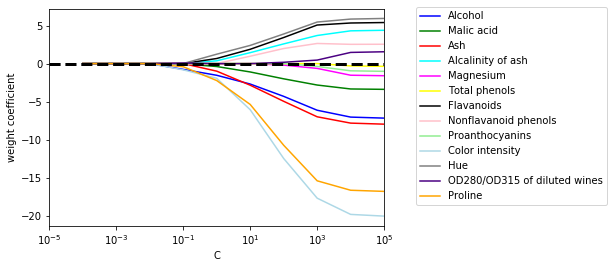

In [74]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue',
         'gray', 'indigo', 'orange']

weight, params = [], []

for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weight.append(lr.coef_[1])
    params.append(10**c)
    
weight = np.array(weight)

for column, color in zip(range(weight.shape[1]), colors):
    plt.plot(params, weight[:, column],
            label = df_wine.columns[column + 1],
            color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc = 'upper center', bbox_to_anchor=(1.38,1.03), ncol=1, fancybox=True)
plt.show()

### 순차 특성 선택 알고리즘

* 모델 복잡도를 줄이고 과대적합을 피하는 다른 방법은 특성 선택을 통한 차원 축소!
* 규제가 없는 모델에서 특히 유용함
* 차원 축소 기법에는 두 개의 주요 카테고리인 특성 선택(feature selection)과 특성 추출(feature extraction)이 있음
* 특성 선택은 원본 특성에서 일부를 선택함
* 특성 추출은 일련의 특성에서 얻은 정보로 새로운 특성을 만듬

* 순차 특성 선택(sequential feature selection) 알고리즘은 탐욕적 탐색 알고리즘(greedy search algorithm)으로 초기 d 차원의 특성 공간을 k < d인 k 차원의 특성 부분 공간으로 축소함.
* 특성 선택 알고리즘은 주어진 문제에 가장 관련이 높은 특성 부분 집합을 자동으로 선택하는 것이 목적
* 관계없는 특성이나 잡음을 제거하여 곗나 효율성을 높이고 모델의 일반화 오차를 줄임
* 규제를 제공하지 않는 알고리즘을 사용할 때 유용함
* 전통적인 순차 특성 선택 알고리즘은 순차 후진 선택(Sequential Backward selection, SBS)
* 계산 효율성을 향상하기 위해 모델 성능을 가능한 적게 희생하면서 초기 특성의 부분 공간으로 차원을 축소함
* 과대적합의 문제를 안고 있는 모델이라면 SBS가 예측 성능을 높일 수도 있음

* 탐욕적 알고리즘(greedy algorithm)은 조합 탐색(combinatorial search) 문제의 각 단계에서 국부적으로 최적의 선택을 함
* 일반적으로 해당 문제에 대한 차선의 솔루션을 만듬
* 완전 탐색 알고리즘(exhaustive search algorithm)은 모든 가능한 조합을 평가하므로 최적의 솔루션을 찾을 것이라고 보장됨
* 실전에서는 완전 탐색이 게산하기 불가능한 경우가 많고 탐욕적 알고리즘이 덜 복잡하고 효율적으로 계산할 수 있는 솔루션을 만들 수 있음

* SBS 알고리즘은 새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거함
* 각 단게에서 어떤 특성을 제거할지 판단하기 위해 최소화할 기준 함수를 정의함
* 기준 함수에서 계산한 값은 어떤 특성을 제거하기 전후의 모델 성능 차이
* 각 단게에서 제거할 특성은 기준 값이 가장 큰 특성으로 정의할 수 있음
* 이해하기 쉽게 말하면 각 단게에서 제거했을 때 성능 손실이 최대가 되는 특성을 제거함

-- 순서 -- 
1. 알고리즘을 k=d로 초기화. d는 전체 특성 공간 X_d의 차원
2. 조건 x = argmax J(X_k - x)를 최대화 하는 특성 x를 결정함. 여기서 x는 X_k에 포함
3. 특성 집합에서 특성 x를 제거함. 즉, X_k-1: = X_k - x; k:=k-1
4. k가 목표하는 특성 개수가 되면 종료함. 아니면 2단계로 돌아감

##### 사이킷런에서는 SBS를 제공하지 않으므로 책에선 직접 구현함

# 랜덤 포레스트의 특성 중요도 사용

* 데이터셋에서 유용한 특성을 선택하는 또 다른 방법은 앙상블 기법인 랜덤 포레스트를 이용하는 것
* 랜덤 포레스트를 사용하면 앙상블에 참여한 모든 결정 트리에서 계산한 평균적인 불순도 감소로 특성 중요도를 측정할 수 있음
* 데이터셋이 선형적으로 구분 가능한지 여부를 가정할 필요도 없음
* 사이킷런의 랜덤 포레스트 구현은 특성 중요도 값을 알아서 수집함
* 트리 기반은 표준화나 정규화 필요 X

 1) Alcohol                        0.185453
 2) Flavanoids                     0.174751
 3) Alcalinity of ash              0.143920
 4) Malic acid                     0.136162
 5) Proline                        0.118529
 6) Ash                            0.058739
 7) Nonflavanoid phenols           0.050872
 8) Proanthocyanins                0.031357
 9) OD280/OD315 of diluted wines   0.025648
10) Magnesium                      0.025570
11) Color intensity                0.022366
12) Total phenols                  0.013354
13) Hue                            0.013279


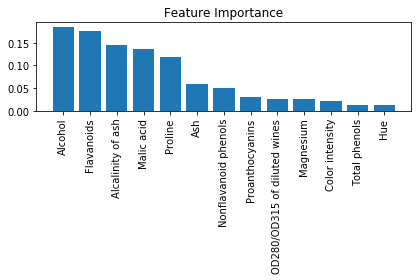

In [76]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

importance = forest.feature_importances_[::-1]

indices = np.argsort(importance)[::-1]

for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' % (f + 1, 30, feat_labels[indices[f]], importance[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importance[indices], align='center')

plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [98]:
np.argsort(importance)[::-1]

array([ 0,  6,  3,  1, 12,  2,  7,  8, 11,  4,  9,  5, 10], dtype=int64)

In [99]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수 : ', X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수 :  5


In [102]:
for f in range(X_selected.shape[1]):
    print('%d) %-*s %f' % (f + 1, 30, feat_labels[indices[f]], importance[indices[f]]))

1) Alcohol                        0.185453
2) Flavanoids                     0.174751
3) Alcalinity of ash              0.143920
4) Malic acid                     0.136162
5) Proline                        0.118529
